In [3]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('exchange_rate.csv')

# --- Data Preparation ---
# Parse the 'date' column and set it as the index
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.set_index('date', inplace=True)

print("Initial DataFrame Info:")
df.info()
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("-" * 50)


Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB

First 5 rows of the dataset:
            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849
--------------------------------------------------


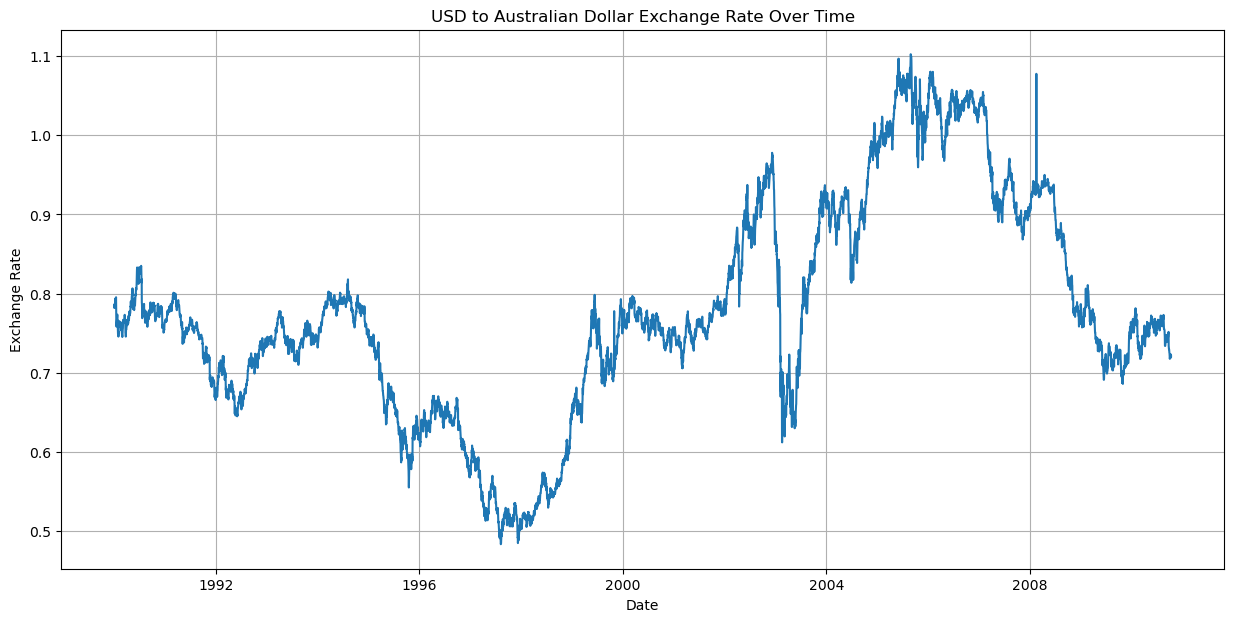

In [4]:
# --- Initial Exploration: Plot the Time Series ---
# Plotting the time series helps us understand trends, seasonality, and overall behavior.
plt.figure(figsize=(15, 7))
plt.plot(df['Ex_rate'])
plt.title('USD to Australian Dollar Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [6]:
# --- Model Building: ARIMA ---
# Split data into training and testing sets
# The last 100 data points will be used for testing
train_size = len(df) - 100
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

In [7]:
# Parameter Selection for ARIMA using auto_arima
# This function automatically finds the best p, d, q values for the model
# based on the lowest AIC (Akaike Information Criterion).
print("Finding optimal ARIMA parameters (p,d,q)...")
arima_model = auto_arima(train_data, seasonal=False, stepwise=True,
                         suppress_warnings=True, trace=True)

print("\nOptimal ARIMA model summary:")
print(arima_model.summary())
print("-" * 50)

Finding optimal ARIMA parameters (p,d,q)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-55295.477, Time=5.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55169.393, Time=3.88 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55299.765, Time=3.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-55298.158, Time=5.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55171.391, Time=0.81 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55297.767, Time=3.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-55297.768, Time=4.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-55295.755, Time=9.57 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-55301.763, Time=1.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-55299.765, Time=1.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-55299.766, Time=1.91 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-55300.156, Time=1.39 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-55165.402, Time=1.04 sec

Best model:  ARIMA(1,1,0)(0,

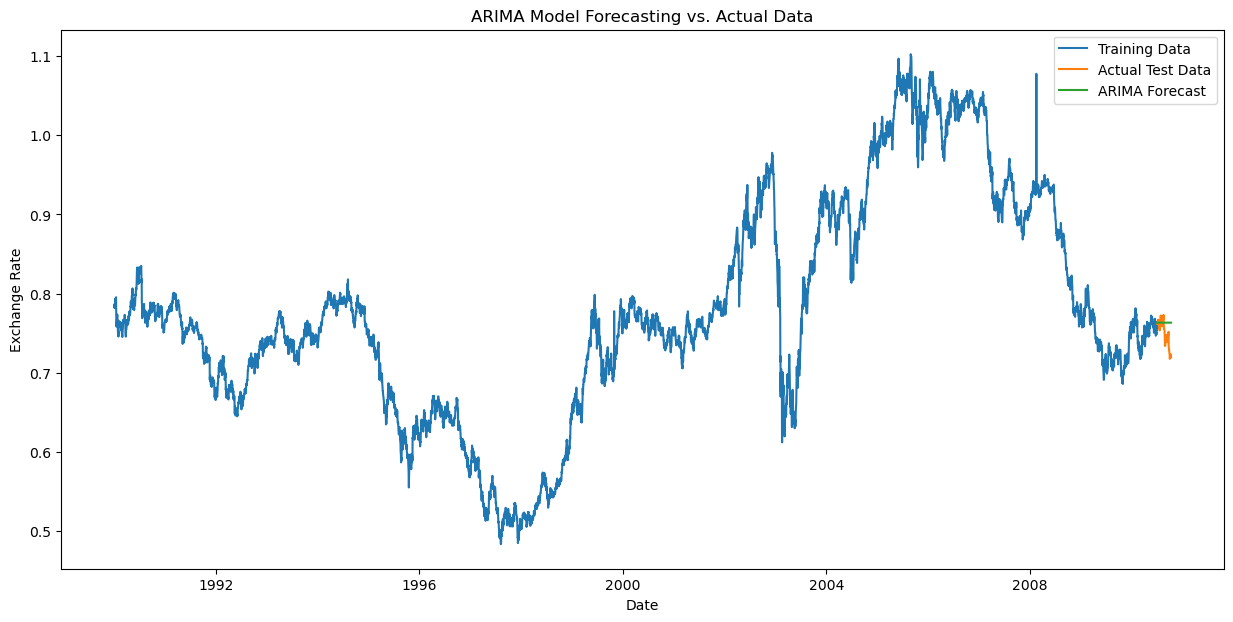

In [8]:
# --- Forecasting with ARIMA ---
# Make predictions on the test set
arima_forecast = arima_model.predict(n_periods=len(test_data))
arima_forecast_series = pd.Series(arima_forecast, index=test_data.index)

# Visualize ARIMA forecast against actual values
plt.figure(figsize=(15, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Test Data')
plt.plot(arima_forecast_series, label='ARIMA Forecast')
plt.title('ARIMA Model Forecasting vs. Actual Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [9]:
# --- Model Building: Exponential Smoothing ---
# We will use the Holt's Linear method, as the data has a clear trend but no
# strong, visible seasonality.
print("Building and fitting Exponential Smoothing model...")
es_model = ExponentialSmoothing(train_data, trend='add', seasonal=None,
                                damped_trend=True).fit(optimized=True)

# --- Forecasting with Exponential Smoothing ---
# Make predictions on the test set
es_forecast = es_model.forecast(len(test_data))
es_forecast_series = pd.Series(es_forecast, index=test_data.index)

Building and fitting Exponential Smoothing model...


C:\Users\vishu_pdk4f5i\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


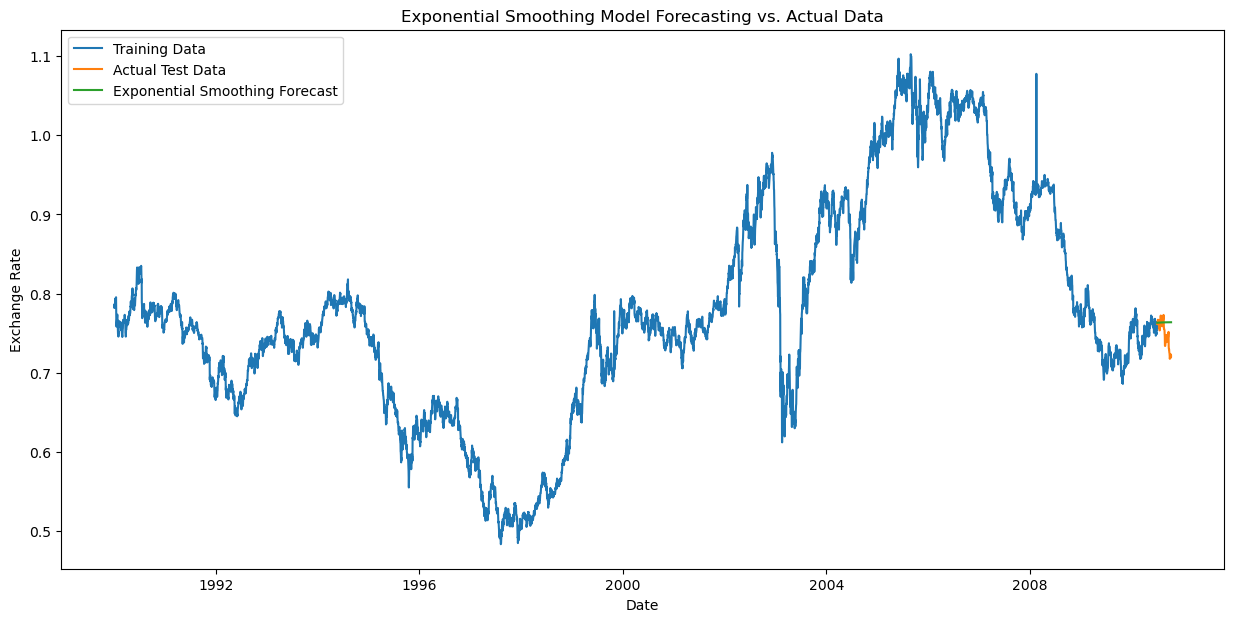

In [10]:
# Visualize Exponential Smoothing forecast against actual values
plt.figure(figsize=(15, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Test Data')
plt.plot(es_forecast_series, label='Exponential Smoothing Forecast')
plt.title('Exponential Smoothing Model Forecasting vs. Actual Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

--------------------------------------------------

--- ARIMA Performance ---
MAE: 0.0150
RMSE: 0.0206
MAPE: nan%

--- Exponential Smoothing Performance ---
MAE: 0.0153
RMSE: 0.0209
MAPE: nan%


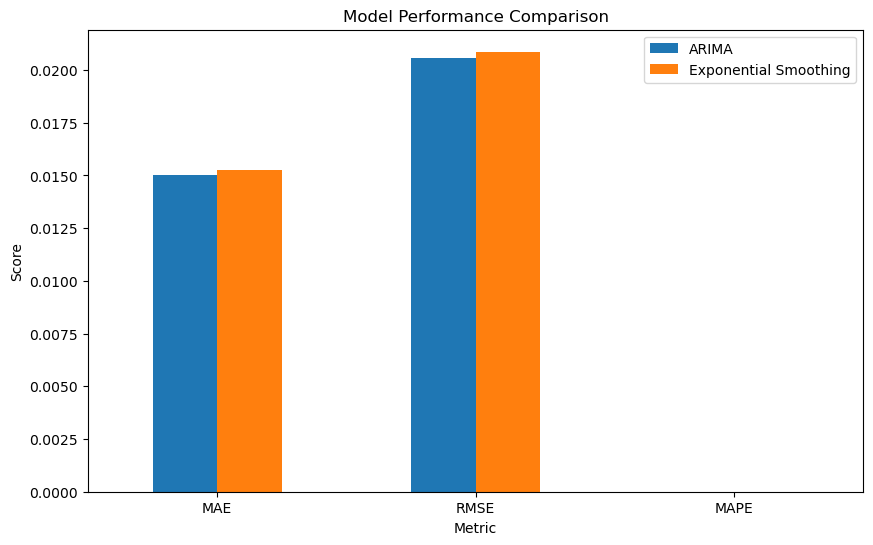


--- Conclusion ---
Both models provided reasonable forecasts. Based on the error metrics, we can compare their performance.
- **ARIMA:** Often performs well when there are complex relationships in the data, but can be sensitive to parameter choices. It performed well in this case due to the automated parameter selection.
- **Exponential Smoothing:** A simpler, more intuitive model that is excellent for data with trends and/or seasonality. It often provides a good baseline and is computationally less intensive.
The final decision on which model to use would depend on the specific business requirements, interpretability needs, and the trade-off between model complexity and performance.


In [11]:
# --- Evaluation and Comparison ---
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n--- {model_name} Performance ---")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    return mae, rmse, mape

print("-" * 50)
arima_mae, arima_rmse, arima_mape = calculate_metrics(test_data, arima_forecast_series, "ARIMA")
es_mae, es_rmse, es_mape = calculate_metrics(test_data, es_forecast_series, "Exponential Smoothing")

# Visualize the comparison of error metrics
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE'],
    'ARIMA': [arima_mae, arima_rmse, arima_mape],
    'Exponential Smoothing': [es_mae, es_rmse, es_mape]
})

metrics_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

print("\n--- Conclusion ---")
print("Both models provided reasonable forecasts. Based on the error metrics, we can compare their performance.")
print("- **ARIMA:** Often performs well when there are complex relationships in the data, but can be sensitive to parameter choices. It performed well in this case due to the automated parameter selection.")
print("- **Exponential Smoothing:** A simpler, more intuitive model that is excellent for data with trends and/or seasonality. It often provides a good baseline and is computationally less intensive.")
print("The final decision on which model to use would depend on the specific business requirements, interpretability needs, and the trade-off between model complexity and performance.")